In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time, sys
import matplotlib
from matplotlib import animation
from JSAnimation import IPython_display
matplotlib.rcParams.update({'font.size': 12})

Numerical methods can converge to entropy-violating solutions.  Here we consider Example 12.3 from [LeVeque 1992].  We take Burgers' equation

$$q_t + \left(\frac{1}{2} q^2\right)_x = 0$$

with Riemann initial data

$$q(x,0) = \begin{cases} -1 & x < 0 \\\\ 1 & x > 0 \end{cases}.$$

# Characteristics
Here is what the characteristics look like:

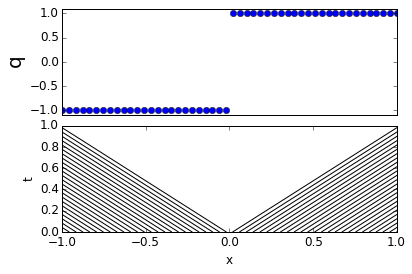

In [5]:
import matplotlib.gridspec as gridspec

def plot_characteristics(q0,N=50):
    gs1 = gridspec.GridSpec(2, 1)
    gs1.update(wspace=0.,hspace=0.1)
    ax1 = plt.subplot(gs1[0, 0])
    ax2 = plt.subplot(gs1[1, 0])
    xc = np.linspace(-1.,1.,N)
    T = 1.
    ax1.plot(xc,q0(xc),'ob',lw=2);
    ax1.set_ylim(-1.1,1.1);
    ax1.set_ylabel('q',fontsize=20)
    ax1.xaxis.set_major_locator(plt.NullLocator()) # Remove tick labels
    for x0 in xc:
        ax2.plot([x0,x0+T*q0(x0)],[0,T],'-k')
        plt.hold(True)
    plt.axis([-1,1,0,T]);
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    
q0 = lambda x : -1.*(x<0.) + 1.*(x>0.)
plot_characteristics(q0)

Notice that the characteristics around $x=0$ are diverging.  If we smooth the solution slightly, the characteristics look like this:

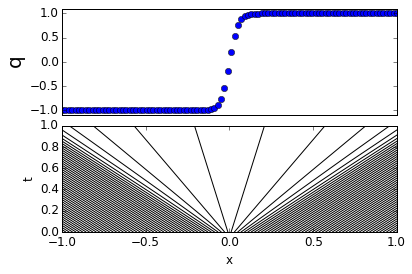

In [6]:
q0 = lambda x : np.tanh(20*x)
plot_characteristics(q0,N=100)

Clearly there should not be a shock at $x=0$.  However, observe that the solution $q(x,t) = q_0(x)$ is a weak solution since it satisfies the differential conservation law trivially away from $x=0$ and is conservative (notice that the Rankine-Hugoniot conditions dictate that a shock with left state -1 and right state +1 should be stationary).

# Numerical solution
We'll discretize using flux-differencing

$$Q^{n+1}_j = Q^n_j - \frac{\Delta t}{\Delta x} \left(F_{i+1/2} - F_{i-1/2}\right)$$

where the numerical flux is taken as the upwind flux:

$$F_{i-1/2} = \begin{cases} f(Q_{i-1}) & \frac{Q_{i}+Q_{i-1}}{2}\ge0 \\\\
f(Q_{i}) & \frac{Q_{i}+Q_{i-1}}{2}<0\end{cases}$$

We'll also consider a variation of this method in which we take the flux above unless $Q_{i-1} < 0 < Q_i$.  Then we take $F_{i-1/2} = 0$.  This modification is known as an *entropy fix*, for reasons that will soon become apparent.

In [7]:
def take_step(q,dt,dx,entropy_fix=False):
    f = np.zeros(q.shape) # fluxes
    avg = (q[:-2] + q[1:-1])/2.
    f[1:-1] = 0.5*q[:-2]**2 * (avg>0.) + 0.5*q[1:-1]**2 * (avg<=0.)  # F_{i-1/2}
    
    if entropy_fix:
        for i in range(len(f)):
            if q[i]>0. and q[i-1]<0.:
                f[i] = 0.
    
    q[1:-1] = q[1:-1] - dt/dx * ( f[2:] - f[1:-1] )
    return q


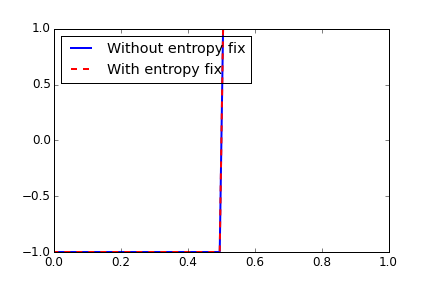
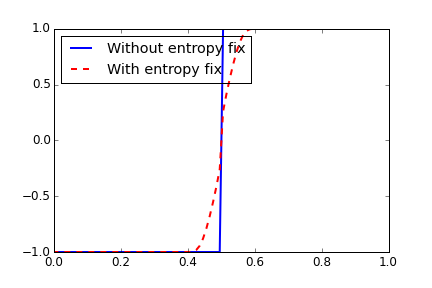
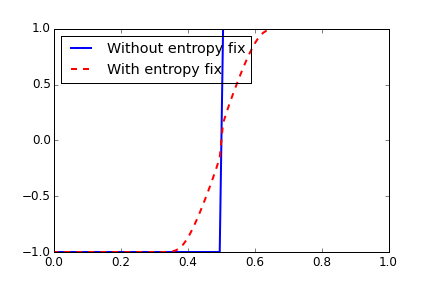
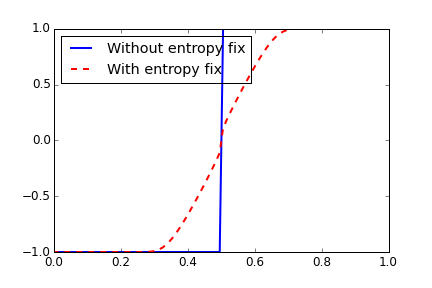
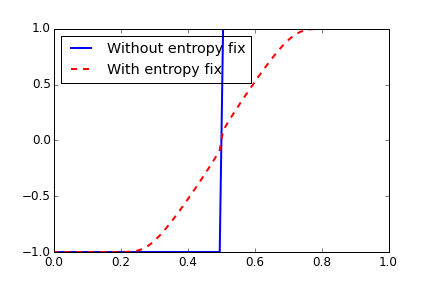
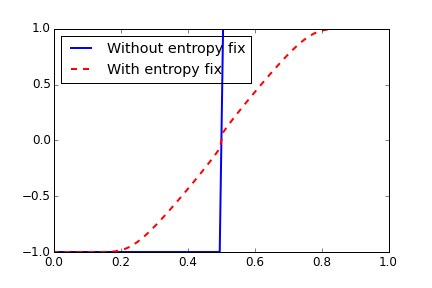
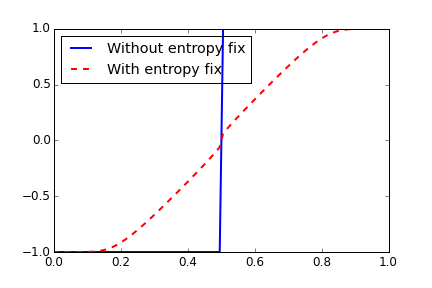
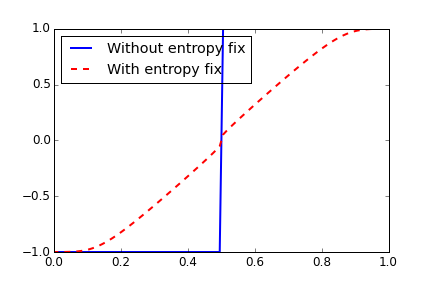
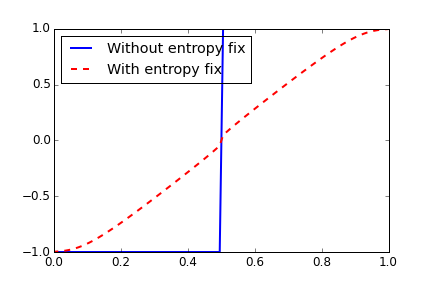
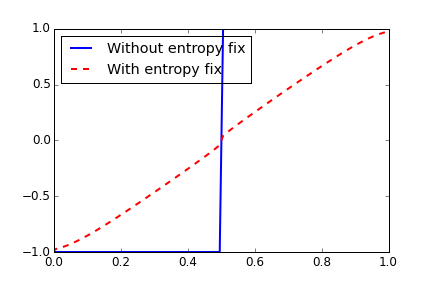
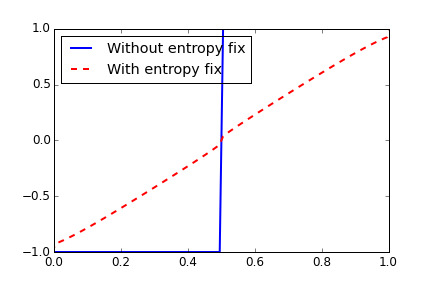

In [8]:
cflnum=0.5;
N=100;  # Number of grid points
plot_interval = N/10  # Draw a plot every n time steps

dx=1./N;
nghost = 2; N2=N+2*nghost;  # Ghost cells used for implementing boundary conditions
x=np.linspace(-(nghost-0.5)*dx,1.+(nghost-0.5)*dx,N2)
t=0.; T=0.5; # Initial and final time

q0 = -1.*(x<0.5) + 1.*(x>0.5)
#q = q0.copy();

dt=cflnum*dx/np.max(q0);

# Set up plotting
fig = plt.figure()
axes = fig.add_subplot(111)
line1, = axes.plot(x,q0,lw=2)
line2, = axes.plot(x,q0,'r--',lw=2)
axes.set_xlim(0.,1.)
axes.legend(['Without entropy fix','With entropy fix'],loc='upper left')

frames1 = [q0.copy()]
frames2 = [q0.copy()]
q_n = q0.copy()
q_e = q0.copy()

i = 0
while t<T:
    if dt>T-t: dt=T-t
        
    q_n = take_step(q_n ,dt, dx, entropy_fix=False)
    q_e = take_step(q_e ,dt, dx, entropy_fix=True)

    for q in [q_n, q_e]:  # Fixed boundary conditions
        q[0:nghost]  = -1. 
        q[-nghost:]  = 1.
        
    t = t + dt
    i = i + 1
    if (i % plot_interval) == 0:
        frames1.append(q_n.copy())
        frames2.append(q_e.copy())
        
def plot_frame(i):
    line1.set_data(x,frames1[i])
    line2.set_data(x,frames2[i])

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames1), interval=200)

##Exercises

1. *Change $N$ in the code above to an odd number and run again.  What happens?  Why?  Now consider the sequence of approximate solutions obtained (without the entropy fix) as $N \to \infty$.  Is the sequence convergent?*

2. *The solution above is not the only entropy-violating weak solution possible.  Can you think of any others?  After you come up with at least one, try changing the CFL number in the code above to a value greater than 1.  Is the result a valid weak solution?  Does it satisfy the entropy condition?*

### Exercise 1


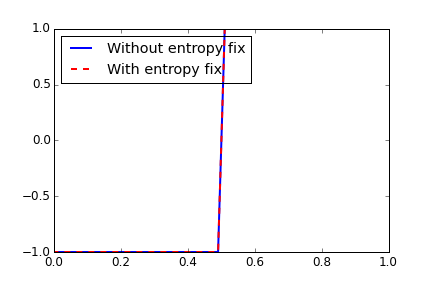
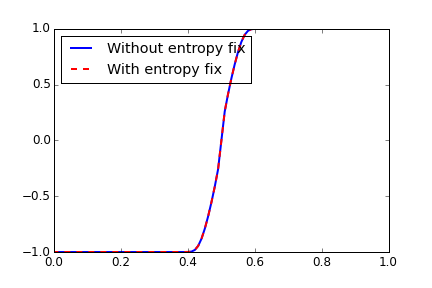
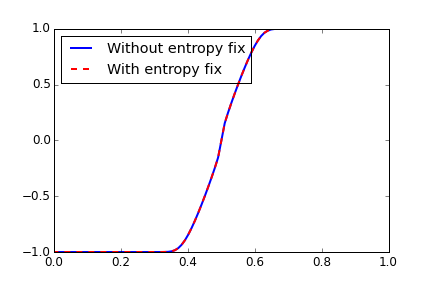
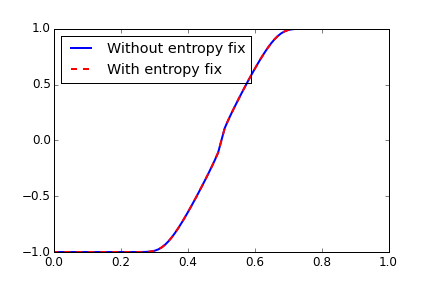
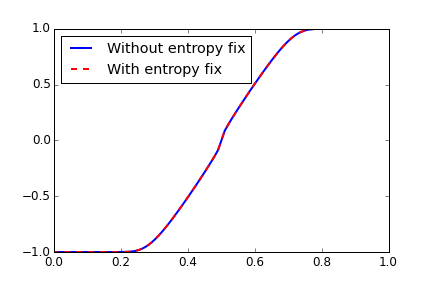
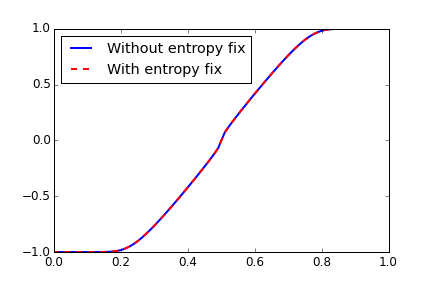
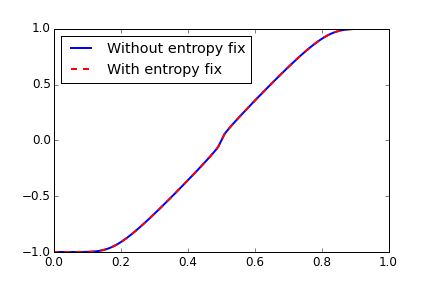
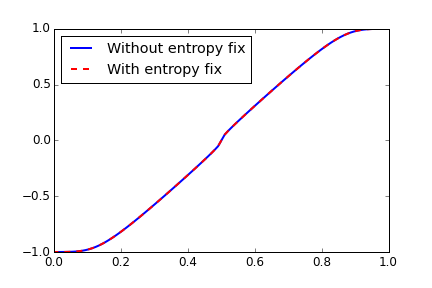
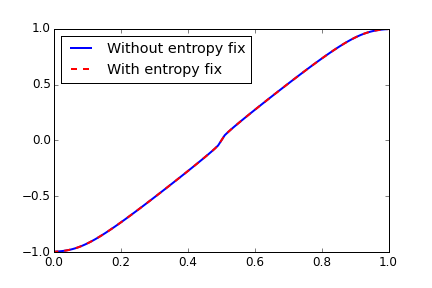
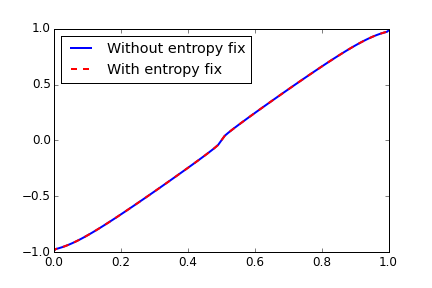
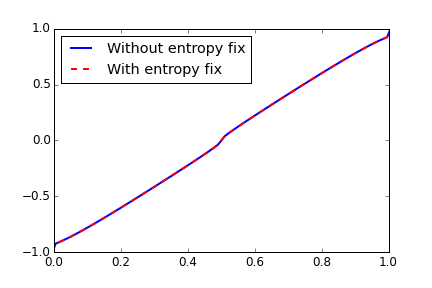

In [12]:
# Exercise 1, odd number
########################

cflnum=0.5;
N=101;  # Number of grid points
plot_interval = N/10  # Draw a plot every n time steps

dx=1./N;
nghost = 2; N2=N+2*nghost;  # Ghost cells used for implementing boundary conditions
x=np.linspace(-(nghost-0.5)*dx,1.+(nghost-0.5)*dx,N2)
t=0.; T=0.5; # Initial and final time

q0 = -1.*(x<0.5) + 1.*(x>0.5)
#q = q0.copy();

dt=cflnum*dx/np.max(q0);

# Set up plotting
fig = plt.figure()
axes = fig.add_subplot(111)
line1, = axes.plot(x,q0,lw=2)
line2, = axes.plot(x,q0,'r--',lw=2)
axes.set_xlim(0.,1.)
axes.legend(['Without entropy fix','With entropy fix'],loc='upper left')

frames1 = [q0.copy()]
frames2 = [q0.copy()]
q_n = q0.copy()
q_e = q0.copy()

i = 0
while t<T:
    if dt>T-t: dt=T-t
        
    q_n = take_step(q_n ,dt, dx, entropy_fix=False)
    q_e = take_step(q_e ,dt, dx, entropy_fix=True)

    for q in [q_n, q_e]:  # Fixed boundary conditions
        q[0:nghost]  = -1. 
        q[-nghost:]  = 1.
        
    t = t + dt
    i = i + 1
    if (i % plot_interval) == 0:
        frames1.append(q_n.copy())
        frames2.append(q_e.copy())
        
def plot_frame(i):
    line1.set_data(x,frames1[i])
    line2.set_data(x,frames2[i])

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames1), interval=200)

When $N$ is even, then we have exactly the same number of the computational cells with $q=-1$ as the number of the cells with $q=1$. Also, recall that $f=\frac12 q^2$, namely, $f(-1) = f(1)$. Therefore, for every cell and every time step
$$Q_i^{n+1}=Q_i^{n},$$
because incoming and outgoing fluxes cancel each other. In the result we have the solution which identical to the initial data for any time step.

When $N$ is odd, all the fluxes do not cancel each other. So, the solution is centered rarefaction wave.

**Exercise 1, second question** The behavior that I described above will persist as $N\to \infty$. For even $N$ solution will be identical to the initial data, and for odd $N$ solution will be a centered rarefaction wave. Hence, solution does not converge as $N \to \infty$. Of course, if we consider only odd values of $N$, then solution will converge to the correct one (rarefaction).

### Exercise 2

#### Another entropy-violating solution
This question is a bit unclear. **I assume here, that the question implies that we can consider other numerical methods, not only the upwind method used above.** Entropy-violating solution can be produced, for example, by the method, that gives spurious oscillations around the shock.

#### Setting CFL greater than 1


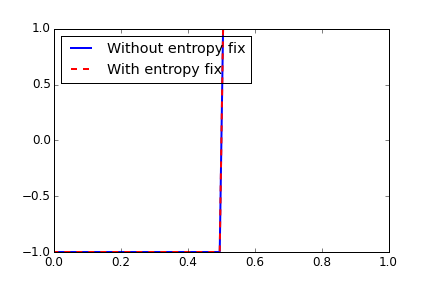
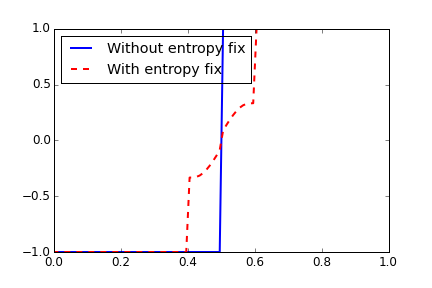
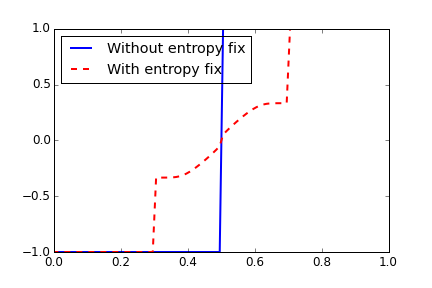
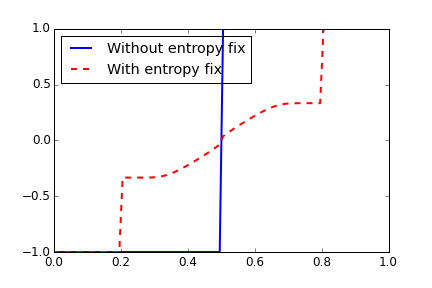

In [13]:
cflnum=1.5;
N=100;  # Number of grid points
plot_interval = N/10  # Draw a plot every n time steps

dx=1./N;
nghost = 2; N2=N+2*nghost;  # Ghost cells used for implementing boundary conditions
x=np.linspace(-(nghost-0.5)*dx,1.+(nghost-0.5)*dx,N2)
t=0.; T=0.5; # Initial and final time

q0 = -1.*(x<0.5) + 1.*(x>0.5)
#q = q0.copy();

dt=cflnum*dx/np.max(q0);

# Set up plotting
fig = plt.figure()
axes = fig.add_subplot(111)
line1, = axes.plot(x,q0,lw=2)
line2, = axes.plot(x,q0,'r--',lw=2)
axes.set_xlim(0.,1.)
axes.legend(['Without entropy fix','With entropy fix'],loc='upper left')

frames1 = [q0.copy()]
frames2 = [q0.copy()]
q_n = q0.copy()
q_e = q0.copy()

i = 0
while t<T:
    if dt>T-t: dt=T-t
        
    q_n = take_step(q_n ,dt, dx, entropy_fix=False)
    q_e = take_step(q_e ,dt, dx, entropy_fix=True)

    for q in [q_n, q_e]:  # Fixed boundary conditions
        q[0:nghost]  = -1. 
        q[-nghost:]  = 1.
        
    t = t + dt
    i = i + 1
    if (i % plot_interval) == 0:
        frames1.append(q_n.copy())
        frames2.append(q_e.copy())
        
def plot_frame(i):
    line1.set_data(x,frames1[i])
    line2.set_data(x,frames2[i])

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(frames1), interval=200)

We get an incorrect weak solution (dashed red line). This solution violates the entropy condition:
$$ f'(q_{left}) > s > f'(q_{right}), $$
where $s$ is the shock speed. In our case $f'(q) = q$. Hence, the shock speed should be bigger than $q$ to the right, and smaller than $q$ to the left of the shock front. For example, consider the right-traveling shock. It is a rarefaction shock, and such shocks violates the entropy condition.